In [1]:
import datajoint as dj

In [2]:
schema = dj.schema('dimitri_university', locals())

Connecting dimitri@localhost:3306


In [3]:
@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned   # university-wide ID number
    ---
    first_name      : varchar(40)
    last_name       : varchar(40)
    sex             : enum('F', 'M', 'U')
    date_of_birth   : date
    student_address : varchar(200) # mailing address
    student_phone   : varchar(14)    
    """
    
@schema
class Department(dj.Manual):
    definition = """
    dept : varchar(6)   # abbreviated department name, e.g. BIOL
    ---
    dept_name    : varchar(200)  # full department name
    dept_address : varchar(200)  # mailing address
    dept_phone   : varchar(14)
    """

@schema
class StudentMajor(dj.Manual):
    definition = """
    -> Student
    ---
    -> Department
    declare_date :  date  # when student declared her major
    """

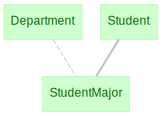

In [4]:
dj.ERD(schema)

In [5]:
@schema
class Course(dj.Manual):
    definition = """
    -> Department
    course  : int unsigned   # course number, e.g. 1010
    ---
    course_name :  varchar(200)  # e.g. "Neurobiology of Sensation and Movement."
    credits     :  decimal(3,1)  # number of credits earned by completing the course
    """
    
    
@schema
class Term(dj.Manual):
    definition = """
    term_year : year
    term      : enum('Spring', 'Summer', 'Fall')
    """

@schema
class Section(dj.Manual):
    definition = """
    -> Course
    -> Term
    section : char(1)
    ---
    auditorium   :  varchar(12)
    """
    
@schema
class CurrentTerm(dj.Manual):
    definition = """
    omega : enum('1')  # surrogate
    ---
    -> Term
    """

@schema
class Enroll(dj.Manual):
    definition = """
    -> Section
    -> Student
    """

@schema
class LetterGrade(dj.Manual):
    definition = """
    grade : char
    ---
    points : decimal(3,2)
    """

@schema
class Grade(dj.Manual):
    definition = """
    -> Enroll
    ---
    -> LetterGrade
    """

In [6]:
a = dj.ERD(schema)

In [7]:
a.save('uni_erd.svg')

In [ ]:
schema.drop()

In [ ]:
import faker
import random
import itertools
fake = faker.Faker()

In [ ]:
def random_sex():
    while True:
        yield random.choice(('F','M'))

Student().insert(dict(
    student_id=student,
    full_name=fake.name_female() if sex=="M" else fake.name_male(),
    sex=sex,
    dob=str(fake.date_time_between(start_date="-65y", end_date="-15y").date())) 
                 for student, sex in zip(range(100), random_sex()))

In [ ]:
Student()

In [ ]:
@schema
class Term(dj.Lookup):
    """
    # Academic term
    year : year 
    semester : enum("Spring", "Summer", "Fall")
    """
    contents = ((year, semester) 
                for year in range(2000,2018) 
                for semester in ('Spring', 'Summer', 'Fall')) 

In [ ]:
Term()

In [ ]:
@schema
class Major(dj.Lookup):
    """ # Major or Department
    major :  char(5)  # short name
    ---
    full_major : varchar(18)
    """
    contents = [
        ["CS", "Computer Science"],
        ["BIOL", "Life Sciences"],
        ["PHYS", "Physics"],
        ["MATH", "Mathematics"]
    ]

In [ ]:
Major()

In [ ]:
@schema
class Course(dj.Lookup):
    """  # available courses
    -> Major
    course  : smallint   
    ----
    course_title : varchar(255)  
    credits : decimal(3,1)  # credit hours
    """

    # from https://www.biology.utah.edu/pdf/undergraduate/Biology_Courses_Master%20List.pdf
    contents = [
        ['BIOL', 1006, 'World of Dinosaurs', 3],
        ['BIOL', 1010, 'Biology in the 21st Century', 3],
        ['BIOL', 1030, 'Human Biology', 3],
        ['BIOL', 1210, 'Principles of Biology', 4],
        ['BIOL', 2010, 'Evolution & Diversity of Life', 3],
        ['BIOL', 2020, 'Principles of Cell Biology',  3],
        ['BIOL', 2021, 'Principles of Cell Science',  4],
        ['BIOL', 2030, 'Principles of Genetics',  3],
        ['BIOL', 2210, 'Human Genetics',3],
        ['BIOL', 2325, 'Human Anatomy', 4],
        ['BIOL', 2330, 'Plants & Society', 3],
        ['BIOL', 2355, 'Field Botany', 2],
        ['BIOL', 2420, 'Human Physiology', 4],
        
        ['PHYS', 2040, 'Classcal Theoretical Physics II', 4],
        ['PHYS', 2060, 'Quantum Mechanics', 3],
        ['PHYS', 2100, 'General Relativity and Cosmology', 3],
        ['PHYS', 2140, 'Statistical Mechanics', 4]]

In [ ]:
Course()

In [ ]:
@schema
class Section(dj.Manual):
    """ # Course sections
    -> Course
    -> Term
    """

In [ ]:
courses = list(Course().fetch.keys())

Section().insert(
    dict(**term_key, **course_key)
    for term_key in Term().fetch.keys()
    for course_key in random.sample(courses, 8))

In [ ]:
Section()

In [ ]:
@schema
class Enroll(dj.Manual):
    """
    # Student enrollment in sections
    -> Student
    -> Course
    ---
    -> Section    
    """

In [ ]:
Enroll()

In [ ]:
dj.ERD(schema)

In [ ]:
# sections = list((Section() & 'year>2010').fetch.keys())
# Enroll().insert(dict(**student_key, **section_key)
#     for student_key in Student().fetch.keys()
#     for section_key in random.sample(sections, random.randint(30))
# )

In [ ]:
schema.drop()

In [ ]:
@schema
class Required(dj.Lookup):
    """  # Required courses in each major
    -> Course    
    """
 
    contents = [
        ['BIOL', 1030],
        ['BIOL', 1210],
        ['BIOL', 2010],
        ['BIOL', 2020],
        ['BIOL', 2021],
        ['PHYS', 2040],
        ['PHYS', 2060],
        ['PHYS', 2100]] 
    

In [ ]:
# Students that have taken all required courses
ready = Student()*StudentMajor() - (Student()*StudentMajor()*Required() - (Enroll() & CourseGrade())).proj()

In [ ]:
ready.make_sql()

In [ ]:
(Student()*Required() - Enroll()).make_sql()

In [ ]:
schema.drop()

In [ ]:
@schema
class StudentMajor(dj.Manual):
    """ # Major declared by student
    -> Student
    ---
    -> Major
    """

In [ ]:
@schema
class Grade(dj.Lookup):
    """
    grade : char(2)
    ---
    points : decimal(3,2)
    """
    contents = [
        ['A',  4.00],
        ['A-', 3.67],
        ['B+', 3.33],
        ['B',  3.00],
        ['B-', 2.67],
        ['C+', 2.33],
        ['C',  2.00],
        ['C-', 1.67],
    ]

In [ ]:
@schema
class CourseGrade(dj.Lookup):
    """
    -> Enroll
    ---
    -> Grade
    """